## This file implement U-Net, training U-net, evaluate different methods

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.models import load_model
import os
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/singlecoil_training.zip" -d "/content/"
!unzip -uq "/content/drive/MyDrive/singlecoil_test.zip" -d "/content/"

Preparing Dataset

In [ ]:

def load_jpg(img_file):
    image = tf.io.read_file(img_file)
    image = tf.io.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    return image[:, :, 0] 

source_img_train_path = "/content/singlecoil_training/src"
dst_img_train_path = "/content/singlecoil_training/dst"
source_img_test_path = "/content/singlecoil_test/src"
dst_img_test_path = '/content/singlecoil_test/dst'

src_train_files = tf.data.Dataset.list_files(source_img_train_path + '/*.jpg', shuffle=False)
dst_train_files = tf.data.Dataset.list_files(dst_img_train_path + '/*.jpg', shuffle=False)
src_test_files = tf.data.Dataset.list_files(source_img_test_path + '/*.jpg', shuffle=False)
dst_test_files = tf.data.Dataset.list_files(dst_img_test_path + '/*.jpg', shuffle=False)

src_size = len(src_train_files)
val_split_idx = int(0.1 * src_size)

src_train_imgs = src_train_files.map(load_jpg)
dst_train_imgs = dst_train_files.map(load_jpg)
src_test_imgs = src_test_files.map(load_jpg)
dst_test_imgs = dst_test_files.map(load_jpg)


train_imgs_all = tf.data.Dataset.zip((src_train_imgs, dst_train_imgs))
val_ds = train_imgs_all.take(val_split_idx) #.batch(32)
train_ds = train_imgs_all.skip(val_split_idx) #.batch(32)



In [ ]:
list(src_test_files)[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'/content/singlecoil_test/src/file1000000_slice17.jpg'>

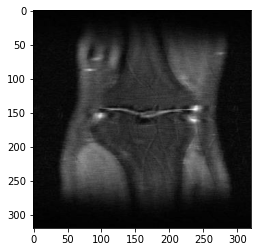

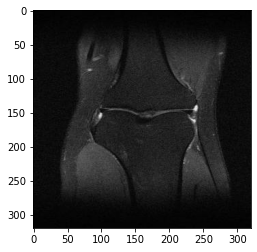

tf.Tensor(b'/content/singlecoil_training/src/file1000000_slice0.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/singlecoil_training/dst/file1000000_slice0.jpg', shape=(), dtype=string)


In [ ]:
plt.imshow(list(val_ds)[10][0].numpy(), cmap='gray')
plt.show()
plt.figure()
plt.imshow(list(val_ds)[10][1].numpy(), cmap='gray')
plt.show()

print(list(src_train_files)[0])
print(list(dst_train_files)[0])

Build U-net baseline model

In [ ]:
# Build U-net
IMAGE_WIDTH = 320
IMAGE_HEIGHT =320

def encode_block(input, num_filters):
    """
    This function is to implement one encode block including 
    two convolution+normalize+ReLU process and one Max pooling 
    in the architecture of U-net model
    Inputs:
        input: the output from last layer
        num_filters: the number of filters, like 32,64,128, 256
    Output:
        z: the output after two convolution+normalize+ReLU
        p: the output after MaxPooling
    """
    z = Conv2D(num_filters, (3, 3), padding="same")(input)
    z = BatchNormalization()(z)
    z = Activation("relu")(z)

    z = Conv2D(num_filters, (3, 3), padding="same")(z)
    z = BatchNormalization()(z)
    z = Activation("relu")(z)

    p = MaxPool2D((2, 2))(z)
    return z, p


def decode_block(input, encode_features, num_filters):
    """ 
    This function is to implement one of decode block, 
    including upsampling, concatennate and two convolution+normalize+ReLU
    Inputs:
        input: the output from last layer
        encode_features: the output from related encode conv_block
        num_filters: the number of filters, like 32,64,128, 256
    Output:
        z: the output after one decode block in the architecture
    """
    z = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    z = Concatenate()([z, encode_features])
    z = Conv2D(num_filters, (3, 3), padding="same")(z)
    z = BatchNormalization()(z)
    z = Activation("relu")(z)

    z = Conv2D(num_filters, (3, 3), padding="same")(z)
    z = BatchNormalization()(z)
    z = Activation("relu")(z)
    return z


def build_unet():
    """
    This function is to implement the architecture of U-net in the paper:
    fast MRI: An open Dataset and Benchmarks for Accelerated MRI
    """
    input_shape = (320, 320, 1)
    inputs = Input(input_shape)

    e_32, p_32 = encode_block(inputs, 32)
    e_64, p_64 = encode_block(p_32, 64)
    e_128, p_128 = encode_block(p_64, 128)
    e_256, p_256 = encode_block(p_128, 256)

    x = Conv2D(256, (3, 3), padding="same")(p_256)
    x = BatchNormalization()(x)
    bottle = Activation("relu")(x)

    d_128 = decode_block(bottle, e_256, 128)
    d_64 = decode_block(d_128, e_128, 64)
    d_32 = decode_block(d_64, e_64, 32)
    d_final = decode_block(d_32, e_32, 32)

    z = Conv2D(16, (1, 1), padding="same", activation='relu')(d_final)

    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(z)

    model = Model(inputs, outputs, name="U-Net")
    # model.summary()
    return model

Evaluation Matrices

In [ ]:
# Define the metrics
    """
    Reconstruction evaluation metrics
    1. Normalized Mean Square Error
    2. Peak Signal-to-Noise Ratio
    3. Structural Similarity
    """
def nmse_metrix(y_truth, y_predict):
    return tf.divide(tf.reduce_sum(tf.math.squared_difference(y_truth, y_predict)), 
                     tf.reduce_sum(y_truth ** 2))

def psnr_metrix(y_truth, y_predict):
    return tf.reduce_mean(tf.image.psnr(y_truth, y_predict, max_val=1.0))

def ssim_metrix(y_truth, y_predict):
    y_truth = tf.expand_dims(y_truth, axis=3)
    y_predict = tf.expand_dims(y_predict, axis=3)

    return tf.reduce_mean(tf.image.ssim(y_truth, y_predict, max_val=1.0, filter_size=7))

Create Downsample Mask

In [ ]:
# Create downsample mask
def generate_mask(width, height):
    mask = np.zeros((height, width), dtype=np.uint8)
    middle = round(width / 2)
    gsp_middle = round(width / 12)
    step_uniform = 2
    step_black = 9
    left_start = step_black
    left_end = middle - round(gsp_middle/2) - step_black
    right_start = middle + round(gsp_middle/2) + step_black
    right_end = width - step_uniform
    
    left = np.arange(left_start,left_end,step_uniform + step_black)
    for i in left:
        mask[:, i:i+step_uniform] = 1

    right = np.arange(right_start, right_end, step_uniform + step_black)
    for i in right:
        mask[:, i:i+step_uniform] = 1

    mask[:, left_end+step_black : right_start - step_black] = 1
    
    return mask
    
MASK = generate_mask(IMAGE_WIDTH, IMAGE_HEIGHT)

Define loss function with frequency domain loss

In [ ]:
# Calculate the k-space of the image
def calculate_k_space(image_gray):
    dft_img = np.fft.fft2(image_gray)
    shift_dft_img = np.fft.fftshift(dft_img)
    return np.abs(shift_dft_img)


def calculate_k_space_tensor(image_gray):
    img_complex = tf.complex(image_gray, tf.zeros_like(image_gray))
    return tf.abs(tf.signal.fftshift(tf.signal.fft2d(img_complex)))


# define our own loss function
def loss_with_frequency(y_true, y_pred):
    """
    This function is to training the U-Net model with loss_function = loss_with_frequency
    Inputs:
      y_true: full sample image 
      y_pred: reconstructed image    
    Output:
      loss: pixel-wise + frequency domain
    """
    loss_pixel = tf.reduce_mean(tf.keras.losses.mean_absolute_error(y_true, y_pred))

    # frequency-domain loss
    gt_k_space = tf.map_fn(calculate_k_space_tensor, y_true)
    pred_k_space = tf.map_fn(calculate_k_space_tensor, y_pred)
    loss_frequency =  tf.divide(tf.reduce_sum(tf.math.squared_difference(gt_k_space[MASK==1], 
                                                                         pred_k_space[MASK==1])), 
                                tf.reduce_sum(gt_k_space[MASK==1] ** 2))

    return loss_pixel+loss_frequency


Training U-net model with our loss function

In [ ]:
# Train the model
def train_model_with_frequency(model, train_ds, val_ds):
    """
    This function is to training the U-Net model with loss_function = loss_with_frequency
    Inputs:
      model: U-Net model 
      train_ds: the training dataset, the type is tf.data.Dataset
      val_ds: the validation dataset, the type is tf.data.Dataset
    Output:
      the model after training
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=loss_with_frequency,
                  metrics=['mae', nmse_metrix, psnr_metrix, ssim_metrix])
    history = model.fit(x=train_ds.batch(32), epochs=15, verbose=1, shuffle=True, validation_data=val_ds.batch(32))
    plot_history(history)
    model.save("single_coil_Unet_new_loss_model")


def train_baseline_model(model, train_ds, val_ds):
    """
    This function is to training the baseline U-Net model, with loss_function = MeanAbsoluteError()
    Inputs:
      model: U-Net model 
      train_ds: the training dataset, the type is tf.data.Dataset
      val_ds: the validation dataset, the type is tf.data.Dataset
    Output:
      the model after training
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=['mae', nmse_metrix, psnr_metrix, ssim_metrix])
    
    history = model.fit(x=train_ds.batch(32), epochs=15, verbose=1, shuffle=True, validation_data=val_ds.batch(32))
    plot_history(history)
    model.save("single_coil_Unet_model")

    
def plot_history(h):
    """ The purpose of this function is to display the history of loss, ssim,psnr, nmse of
    each epoch during the training
    Inputs:
        -- h: history of model
    Output:
        None
    """
    loss = h.history['loss']
    val_loss = h.history['val_loss']

    ssim = h.history['ssim_metrix']
    val_ssim = h.history['val_ssim_metrix']

    psnr = h.history['psnr_metrix']
    val_psnr = h.history['val_psnr_metrix']

    nmse = h.history['nmse_metrix']
    val_nmse = h.history['val_nmse_metrix']

    epochs = range(len(loss))

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs, ssim, 'r', label='Training ssim')
    plt.plot(epochs, val_ssim, 'b', label='Validation ssim')
    plt.title('Training and validation')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs, psnr, 'r', label='Training psnr')
    plt.plot(epochs, val_psnr, 'b', label='Validation psnr')
    plt.title('Training and validation')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs, nmse, 'r', label='Training nmse')
    plt.plot(epochs, val_nmse, 'b', label='Validation nmse')
    plt.title('Training and validation')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

Evaluate the result

In [ ]:
# Model Predict 
def predict_reconstruct_image(test_inputs):
    """ The purpose of this function is predict the reconstruction image
    and display one example of the reconstruction image
    Inputs:
        -- test_inputs: downsampled images
    Output:
        None
    """
    # load model
    model = load_model('single_coil_Unet_model', custom_objects={'nmse_metrix':nmse_metrix, 'psnr_metrix':psnr_metrix, 'ssim_metrix': ssim_metrix})
    preds_test = model.predict(list(test_inputs), verbose=1)

    idx = random.randint(0, len(preds_test))
    plt.imshow(test_inputs[idx], cmap="gray")
    plt.show()
    reconstruction_img = np.squeeze(preds_test[idx])

    plt.imshow(reconstruction_img, cmap="gray")
    plt.show()
    print('ok')

In [ ]:
u_net_model = build_unet()

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


161/161 [==============================] - 179s 947ms/step - loss: 1.1136 - mae: 0.0825 - nmse_metrix: 0.5894 - psnr_metrix: 21.5533 - ssim_metrix: 0.4135 - val_loss: 1.2649 - val_mae: 0.1270 - val_nmse_metrix: 0.6384 - val_psnr_metrix: 17.0476 - val_ssim_metrix: 0.3642
Epoch 2/15
161/161 [==============================] - 144s 890ms/step - loss: 0.1372 - mae: 0.0326 - nmse_metrix: 0.0830 - psnr_metrix: 26.3842 - ssim_metrix: 0.6680 - val_loss: 0.9641 - val_mae: 0.1026 - val_nmse_metrix: 0.5224 - val_psnr_metrix: 17.9575 - val_ssim_metrix: 0.3987
Epoch 3/15
161/161 [==============================] - 145s 897ms/step - loss: 0.1206 - mae: 0.0299 - nmse_metrix: 0.0730 - psnr_metrix: 26.9817 - ssim_metrix: 0.7110 - val_loss: 0.6292 - val_mae: 0.0753 - val_nmse_metrix: 0.3270 - val_psnr_metrix: 19.8517 - val_ssim_metrix: 0.4965
Epoch 4/15
161/161 [==============================] - 145s 900ms/step - loss: 0.1107 - mae: 0.0288 - nmse_metrix: 0.0677 - psnr_metrix: 27.3128 - ssim_metrix: 0.7217

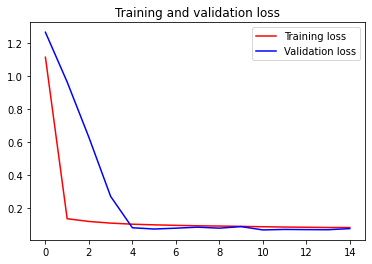

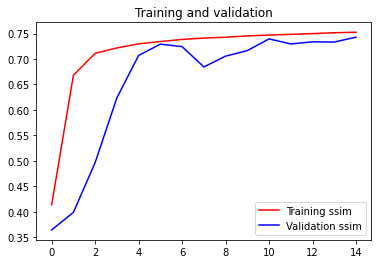

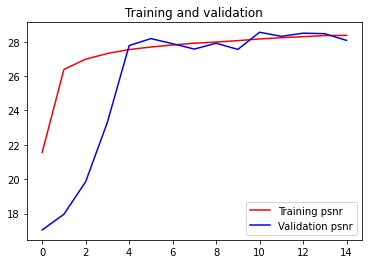

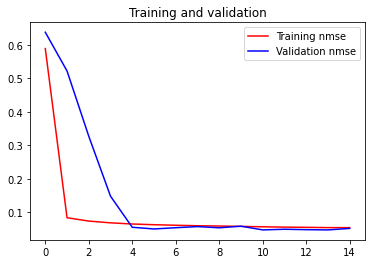

<Figure size 432x288 with 0 Axes>

INFO:tensorflow:Assets written to: single_coil_Unet_model/assets


In [ ]:
train_model_with_frequency(u_net_model, train_ds, val_ds)

In [ ]:
# Calculate the k-space of the image
def calculate_k_space(image_gray):
    dft_img = np.fft.fft2(image_gray)
    shift_dft_img = np.fft.fftshift(dft_img)
    return shift_dft_img

# k-space correction
def k_space_correction(gt_img, pred_img, mask):
    gt_k_space = calculate_k_space(gt_img)
    pred_k_space = calculate_k_space(pred_img)
    
    correct_k_space = pred_k_space.copy()
    correct_k_space[mask==1] = gt_k_space[mask==1]
  
    return correct_k_space


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


161/161 [==============================] - 146s 882ms/step - loss: 0.0563 - mae: 0.0265 - nmse_metrix: 0.0585 - psnr_metrix: 27.9715 - ssim_metrix: 0.7427 - val_loss: 0.5337 - val_mae: 0.0784 - val_nmse_metrix: 0.5389 - val_psnr_metrix: 17.7171 - val_ssim_metrix: 0.6276
Epoch 2/15
161/161 [==============================] - 144s 891ms/step - loss: 0.0519 - mae: 0.0254 - nmse_metrix: 0.0541 - psnr_metrix: 28.3043 - ssim_metrix: 0.7509 - val_loss: 0.0449 - val_mae: 0.0247 - val_nmse_metrix: 0.0475 - val_psnr_metrix: 28.4749 - val_ssim_metrix: 0.7439
Epoch 3/15
161/161 [==============================] - 145s 898ms/step - loss: 0.0507 - mae: 0.0251 - nmse_metrix: 0.0528 - psnr_metrix: 28.4050 - ssim_metrix: 0.7534 - val_loss: 0.0493 - val_mae: 0.0263 - val_nmse_metrix: 0.0519 - val_psnr_metrix: 28.2615 - val_ssim_metrix: 0.7312
Epoch 4/15
161/161 [==============================] - 145s 902ms/step - loss: 0.0493 - mae: 0.0247 - nmse_metrix: 0.0514 - psnr_metrix: 28.5276 - ssim_metrix: 0.7557

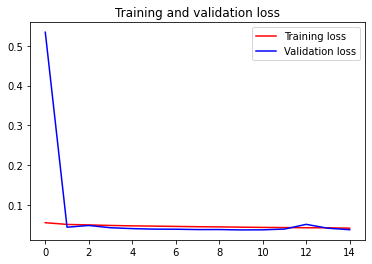

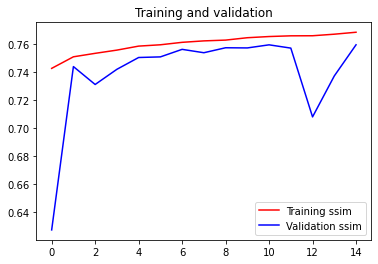

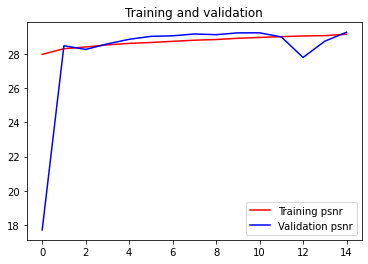

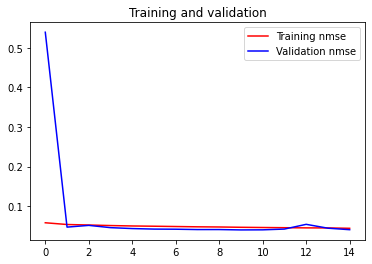

<Figure size 432x288 with 0 Axes>

INFO:tensorflow:Assets written to: single_coil_Unet_model/assets


In [ ]:
train_model_with_frequency(u_net_model, train_ds, val_ds)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


161/161 [==============================] - 146s 881ms/step - loss: 0.0472 - mae: 0.0231 - nmse_metrix: 0.0462 - psnr_metrix: 29.0081 - ssim_metrix: 0.7671 - val_loss: 0.0431 - val_mae: 0.0230 - val_nmse_metrix: 0.0429 - val_psnr_metrix: 29.0285 - val_ssim_metrix: 0.7640
Epoch 2/15
161/161 [==============================] - 144s 891ms/step - loss: 0.0453 - mae: 0.0227 - nmse_metrix: 0.0451 - psnr_metrix: 29.1058 - ssim_metrix: 0.7699 - val_loss: 0.0404 - val_mae: 0.0222 - val_nmse_metrix: 0.0409 - val_psnr_metrix: 29.2773 - val_ssim_metrix: 0.7675
Epoch 3/15
161/161 [==============================] - 145s 900ms/step - loss: 0.0448 - mae: 0.0226 - nmse_metrix: 0.0449 - psnr_metrix: 29.1206 - ssim_metrix: 0.7707 - val_loss: 0.0496 - val_mae: 0.0243 - val_nmse_metrix: 0.0491 - val_psnr_metrix: 28.5163 - val_ssim_metrix: 0.7635
Epoch 4/15
161/161 [==============================] - 145s 900ms/step - loss: 0.0443 - mae: 0.0225 - nmse_metrix: 0.0448 - psnr_metrix: 29.1394 - ssim_metrix: 0.7709

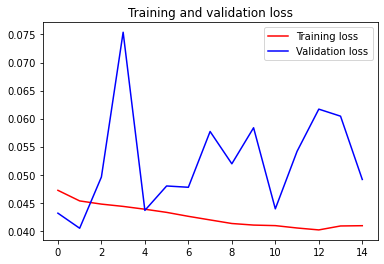

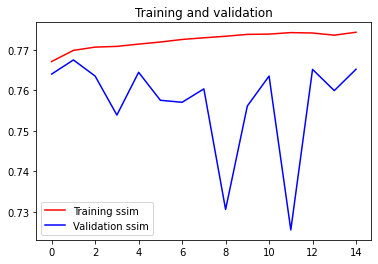

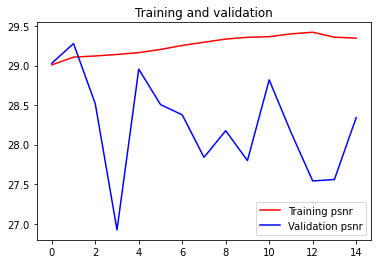

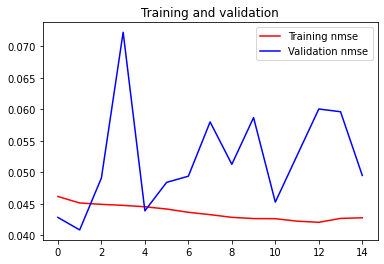

<Figure size 432x288 with 0 Axes>

INFO:tensorflow:Assets written to: single_coil_Unet_model/assets


In [ ]:
train_model_with_frequency(u_net_model, train_ds, val_ds)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


161/161 [==============================] - 137s 833ms/step - loss: 0.0215 - mae: 0.0215 - nmse_metrix: 0.0406 - psnr_metrix: 29.5923 - ssim_metrix: 0.7755 - val_loss: 0.0223 - val_mae: 0.0223 - val_nmse_metrix: 0.0415 - val_psnr_metrix: 29.1732 - val_ssim_metrix: 0.7672
Epoch 2/15
161/161 [==============================] - 137s 849ms/step - loss: 0.0211 - mae: 0.0211 - nmse_metrix: 0.0395 - psnr_metrix: 29.7150 - ssim_metrix: 0.7781 - val_loss: 0.0228 - val_mae: 0.0228 - val_nmse_metrix: 0.0444 - val_psnr_metrix: 28.8643 - val_ssim_metrix: 0.7687
Epoch 3/15
161/161 [==============================] - 138s 858ms/step - loss: 0.0210 - mae: 0.0210 - nmse_metrix: 0.0391 - psnr_metrix: 29.7595 - ssim_metrix: 0.7792 - val_loss: 0.0221 - val_mae: 0.0221 - val_nmse_metrix: 0.0415 - val_psnr_metrix: 29.1741 - val_ssim_metrix: 0.7699
Epoch 4/15
161/161 [==============================] - 139s 860ms/step - loss: 0.0208 - mae: 0.0208 - nmse_metrix: 0.0386 - psnr_metrix: 29.8135 - ssim_metrix: 0.7803

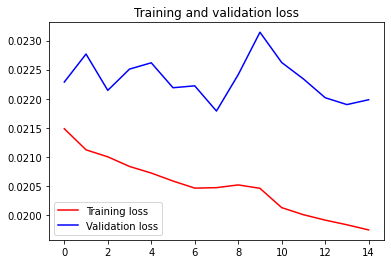

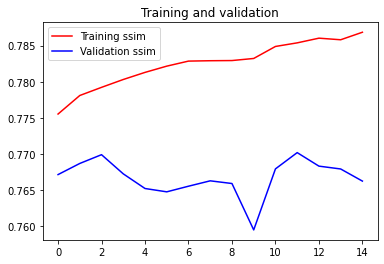

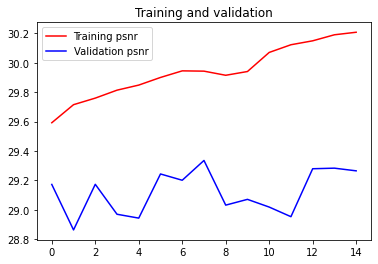

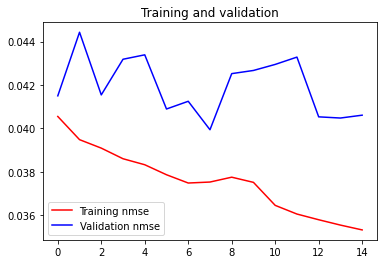

<Figure size 432x288 with 0 Axes>

INFO:tensorflow:Assets written to: single_coil_Unet_model/assets


In [ ]:
train_model_with_frequency(u_net_model, train_ds, val_ds)

1/1 [==============================] - 0s 448ms/step


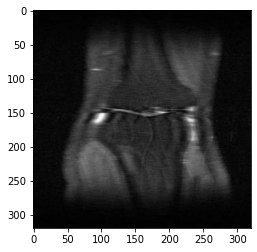

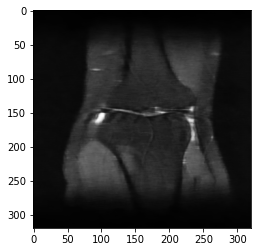

In [ ]:
src_test_img_list = list(src_test_imgs)
tt = src_test_img_list[0].numpy()
x = np.expand_dims(tt, axis=0)
preds_test = u_net_model.predict(x, verbose=1)

idx = random.randint(0, len(preds_test))
plt.imshow(src_test_img_list[0], cmap="gray")
plt.show()
reconstruction_img = np.squeeze(preds_test)

plt.imshow(reconstruction_img, cmap="gray")
plt.show()

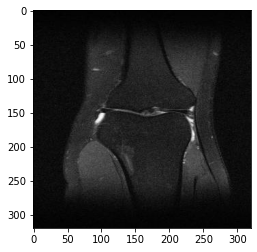

In [ ]:
dst_test_img_list = list(dst_test_imgs)
plt.imshow(dst_test_img_list[0], cmap="gray")
plt.show()

## get the reconstruction images from u-net

In [ ]:
preds_test = u_net_model.predict(np.array(list(src_test_imgs), np.float32), verbose=1) 

45/45 [==============================] - 12s 282ms/step


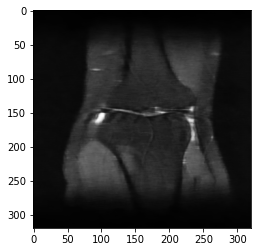

In [ ]:
plt.imshow(np.squeeze(preds_test[0]), cmap="gray")
plt.show()

## save the reconstruct images after u-net

In [ ]:
import re
def get_file_list(src_test_files):
  file_list = []
  ttt = list(src_test_files)  
  filename_re = re.compile('(?<=^b\').+\.jpg(?=\'$)')
  for i in range(len(ttt)):
    aaa = ttt[i].numpy()
    file_list.append(filename_re.search(str(aaa)).group())
    # print(filename_re.search(str(aaa)).group())
  return file_list

In [ ]:
test_file_list = get_file_list(src_test_files)

In [ ]:
from pathlib import Path 
# Save the reconstruction images
dst_path = './reconstruct_img_our'

for reconstruct_img, test_file in zip(preds_test, test_file_list):
  reconstruction_img = np.squeeze(reconstruct_img)
  file_name = Path(test_file).name
  dst_file = os.path.join(dst_path, file_name)
  plt.imsave(dst_file, reconstruction_img, cmap="gray")

In [ ]:
dst_test_img_list = list(dst_test_imgs)
plt.imshow(dst_test_img_list[0], cmap="gray")
plt.show()

plt.imshow(np.squeeze(preds_test[0]), cmap="gray")
plt.show()

In [ ]:
# k-space correction
def k_space_correction(gt_k_space, pred_k_space):
    """
    This function is to using ground truth k-space data to correct the predict image k-space
    with the global down-sample MASK
    Inputs:
      gt_k_space: ground truth k-space data
      pred_k_space: the predict image k-space
    Output:
      correct_k_space: k-space data after correction
    """
    correct_k_space = pred_k_space.copy()
    correct_k_space[MASK==1] = gt_k_space[MASK==1]  
    return correct_k_space

def calculate_k_space(image_gray):
    """
    This function is to calculate the k-space data of a gray image
    Inputs:
      image_gray: gray image
    Output:
      shift_dft_img: k-space data of the input gray image
    """
    dft_img = np.fft.fft2(image_gray)
    shift_dft_img = np.fft.fftshift(dft_img)
    return shift_dft_img

# Reconstruct gray scale image from k_space data
def calculate_image_from_kspace(k_space_data):
    """
    This function is to reconstruct image from the k-space data 
    Inputs:
      k_space_data: the k-space data
    Output:
      img: gray image reconstructed from k-space data 
    """
    img = np.abs(np.fft.ifft2(k_space_data))
    # plt.figure(figsize=(9,9))
    # plt.axis('off')
    # plt.title("Reconstruct Grayscale image")
    # plt.imshow(img, cmap='gray')
    return img

  

In [ ]:
def ssim_metrix_t(y_truth, y_predict):
    return tf.reduce_mean(tf.image.ssim(y_truth, y_predict, max_val=1.0, filter_size=7))

def psnr_metrix_test(y_truth, y_predict):
    return tf.image.psnr(y_truth, y_predict, max_val=1.0)

### k-correct of the predict images

In [ ]:
# k-correct of the predict images
nmse = 0.0
ssim = 0.0
psnr = 0.0


for gt_test, pred_test in zip(dst_test_img_list, preds_test):
  pred_test = np.squeeze(pred_test)
  gt_k_space = calculate_k_space(gt_test)
  pred_k_space = calculate_k_space(pred_test)
  correct_k_space = k_space_correction(gt_k_space, pred_k_space)
  correct_img = calculate_image_from_kspace(correct_k_space)

  nmse += nmse_metrix(gt_test, correct_img)
  im1 = tf.image.convert_image_dtype(gt_test, tf.float32)
  im2 = tf.image.convert_image_dtype(correct_img, tf.float32)
  gt_test = tf.expand_dims(im1, axis=0)
  gt_test = tf.expand_dims(gt_test, axis=-1)

  correct_img = tf.expand_dims(im2, axis=0)
  correct_img = tf.expand_dims(correct_img, axis=-1)
  ssim += ssim_metrix_t(gt_test, correct_img)

  psnr += psnr_metrix_test(gt_test, correct_img)
  
nmse = nmse / len(dst_test_img_list)
ssim = ssim / len(dst_test_img_list)
psnr = psnr / len(dst_test_img_list)

print(f'nmse = {nmse}, ssim = {ssim}, psnr = {psnr}')

nmse = 0.018539942800998688, ssim = 0.8609715700149536, psnr = [33.86383]


## save the images after k-correction

In [ ]:
dst_path = './k_correct_img_our'
for gt_test, pred_test, test_file in zip(dst_test_img_list, preds_test, test_file_list):
  pred_test = np.squeeze(pred_test)
  gt_k_space = calculate_k_space(gt_test)
  pred_k_space = calculate_k_space(pred_test)
  correct_k_space = k_space_correction(gt_k_space, pred_k_space)
  correct_img = calculate_image_from_kspace(correct_k_space)

  file_name = Path(test_file).name
  dst_file = os.path.join(dst_path, file_name)
  plt.imsave(dst_file, correct_img, cmap="gray")